In [61]:
"""
Hierarchical Classifier + K-TSP (Top-Scoring Gene Pairs) Pipeline
"""

import numpy as np
import pandas as pd
from typing import List, Tuple, Dict, Optional, Union
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


# ==============================
# LABEL NORMALIZATION
# ==============================

LABEL_MAP = {
    "tumor": ["tumor", "t", "cancer"],
    "normal": ["normal", "n", "control"],
    "all": ["all"],
    "aml": ["aml"],
    "adca": ["adca"],
    "mesothelioma": ["mesothelioma"],
    "dlbcl": ["dlbcl"],
    "fl": ["fl"]
}


def normalize_label(label: str) -> str:
    """Normalize label to standard format."""
    label = label.strip().lower()
    
    for normalized, variants in LABEL_MAP.items():
        if label in variants:
            return normalized
    
    return label


def _is_numeric_row(values: List[str]) -> bool:
    """Check if row contains only numeric values."""
    try:
        return all(pd.to_numeric(v, errors='coerce').notna().all() for v in values if str(v).strip())
    except:
        return False


def _generate_default_labels(n_samples: int) -> List[str]:
    """Generate default tumor/normal labels when none provided."""
    half = n_samples // 2
    return ["tumor"] * half + ["normal"] * (n_samples - half)


# ==============================
# FUNCTION 1: LOAD_AND_NORMALIZE_DATA
# ==============================

def load_and_normalize_data(file_path: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load gene expression matrix and normalize data.
    
    Input:
        - file_path: path to data file
    Output:
        - X: gene expression matrix (genes × samples)
        - y: labels as integers
    """
    df = pd.read_csv(file_path, sep=',', header=None)

    first_row = df.iloc[0].astype(str).tolist()

    # 是否第一行是标签
    labels_in_first_row = not all(
        v.replace('.', '').replace('-', '').isdigit()
        for v in first_row
    )

    if labels_in_first_row:
        labels = [normalize_label(l) for l in first_row]
        data = df.iloc[1:].values.astype(float)
    else:
        data = df.values.astype(float)
        n_samples = data.shape[1]
        labels = ["tumor"] * (n_samples // 2) + ["normal"] * (n_samples - n_samples // 2)

    # 保证 X 是 genes × samples
    if data.shape[0] < data.shape[1]:
        X = data
    else:
        X = data.T

    unique_labels = sorted(set(labels))
    label_map = {l: i for i, l in enumerate(unique_labels)}
    y = np.array([label_map[l] for l in labels])
    
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    print("label unique:", np.unique(y))

    return X, y




In [72]:
# ==============================
# FUNCTION 2: SPLIT_DATA_PROCESSING_LABELS
# ==============================

def split_data_processing_labels(
    X: np.ndarray, 
    y: np.ndarray, 
    test_size: float = 0.2, 
    random_state: int = 42
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Split data into training and testing sets.
    
    Input:
        - X: feature matrix
        - y: labels
        - test_size: proportion of test set
        - random_state: random seed
    Output:
        - X_train, X_test, y_train, y_test
    """
    #X_train, X_test, y_train, y_test = train_test_split(
    #    X.T, y, test_size=test_size, random_state=random_state, stratify=y
    #)
    #return X_train, X_test, y_train, y_test
    
    #idx = np.arange(X.shape[1])

    #train_idx, test_idx = train_test_split(
    #   idx, test_size=test_size, random_state=random_state, stratify=y
    #)

    #X_train = X[:, train_idx]
    #X_test  = X[:, test_idx]
    #y_train = y[train_idx]
    #y_test  = y[test_idx]
    
    X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    stratify=y
    )
    return X_train, X_test, y_train, y_test

In [73]:
# ==============================
# FUNCTION 3: SELECT_TOP_VARIABLE_GENES
# ==============================

def select_top_variable_genes(X_train: np.ndarray, top_n: int = 300) -> np.ndarray:
    """
    Select top N most variable genes based on variance.
    
    Input:
        - X_train: training data (samples × genes)
        - top_n: number of top genes to select
    Output:
        - selected_gene_indices: array of gene indices
    """
    variances = np.var(X_train, axis=0)
    top_indices = np.argsort(variances)[::-1][:top_n]
    return np.sort(top_indices)


In [74]:
# ==============================
# FUNCTION 4: SCORE_TOP_K_GENE_PAIRS
# ==============================

def score_top_k_gene_pairs(
    X_train: np.ndarray,
    y_train: np.ndarray,
    selected_gene_indices: np.ndarray,
    K: int = 10
) -> List[Tuple[int, int, float]]:
    """
    Score all gene pairs and select top K pairs.
    
    Input:
        - X_train: training data (samples × genes)
        - y_train: training labels
        - selected_gene_indices: indices of selected genes
        - K: number of top pairs to return
    Output:
        - top_k_gene_pairs: list of (gene_i, gene_j, score) tuples
    """
    X_selected = X_train[:, selected_gene_indices]
    n_genes = len(selected_gene_indices)
    n_samples = X_selected.shape[0]
    
    # Binarize labels to 0 and 1 for scoring
    unique_labels = np.unique(y_train)
    if len(unique_labels) == 2:
        y_binary = (y_train == unique_labels[1]).astype(int)
    else:
        # For multi-class, use majority class as class 1
        label_counts = Counter(y_train)
        majority_class = label_counts.most_common(1)[0][0]
        y_binary = (y_train == majority_class).astype(int)
    
    pair_scores = []
    
    # Score all pairs
    for i in range(n_genes):
        for j in range(i + 1, n_genes):
            # Predict: if gene_i > gene_j → class 1, else class 0
            predictions = (X_selected[:, i] > X_selected[:, j]).astype(int)
            accuracy = np.mean(predictions == y_binary)
            pair_scores.append((selected_gene_indices[i], selected_gene_indices[j], accuracy))
    
    # Sort by score (descending) and select top K
    pair_scores.sort(key=lambda x: x[2], reverse=True)
    return pair_scores[:K]


In [75]:
# ==============================
# FUNCTION 5: BUILD_HIERARCHICAL_TREE
# ==============================

class TreeNode:
    """Node in hierarchical tree."""
    def __init__(self):
        self.gene_pair = None
        self.left = None
        self.right = None
        self.predicted_class = None
        self.is_leaf = False


class HierarchicalClassifier:
    """Hierarchical classifier using K-TSP gene pairs."""
    
    def __init__(self):
        self.root = None
        self.label_encoder = None
        self.gene_pairs = None
    
    def fit(self, X: np.ndarray, y: np.ndarray, gene_pairs: List[Tuple[int, int, float]]):
        """
        Train hierarchical classifier.
        
        Input:
            - X: training data (samples × genes)
            - y: training labels
            - gene_pairs: list of (gene_i, gene_j, score) tuples
        """
        self.gene_pairs = gene_pairs
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y)
        self.root = self._build_tree(X, y_encoded, 0)
    
    def _build_tree(self, X: np.ndarray, y: np.ndarray, pair_idx: int) -> TreeNode:
        """Recursively build hierarchical tree."""
        node = TreeNode()
        
        # Base case: all samples have same class or no more pairs
        unique_classes = np.unique(y)
        if len(unique_classes) == 1 or pair_idx >= len(self.gene_pairs):
            node.is_leaf = True
            node.predicted_class = unique_classes[0]
            return node
        
        # Get current gene pair
        gene_i, gene_j, _ = self.gene_pairs[pair_idx]
        node.gene_pair = (gene_i, gene_j)
        
        # Split: gene_i > gene_j goes left (major class), else right
        split_mask = X[:, gene_i] > X[:, gene_j]
        X_left = X[split_mask]
        y_left = y[split_mask]
        X_right = X[~split_mask]
        y_right = y[~split_mask]
        
        # If one side is empty, make this a leaf
        if len(y_left) == 0 or len(y_right) == 0:
            node.is_leaf = True
            node.predicted_class = Counter(y).most_common(1)[0][0]
            return node
        
        # Recursively build left and right subtrees
        node.left = self._build_tree(X_left, y_left, pair_idx + 1)
        node.right = self._build_tree(X_right, y_right, pair_idx + 1)
        
        return node
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict classes for samples."""
        predictions = []
        for sample in X:
            pred = self._predict_sample(self.root, sample)
            predictions.append(pred)
        return np.array(predictions)
    
    def _predict_sample(self, node: TreeNode, sample: np.ndarray) -> int:
        """Predict class for a single sample."""
        if node.is_leaf:
            return node.predicted_class
        
        gene_i, gene_j = node.gene_pair
        if sample[gene_i] > sample[gene_j]:
            return self._predict_sample(node.left, sample)
        else:
            return self._predict_sample(node.right, sample)
    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Predict class probabilities (decision scores)."""
        # For hierarchical classifier, use depth-based confidence
        scores = []
        for sample in X:
            score = self._get_decision_score(self.root, sample, depth=0)
            scores.append(score)
        return np.array(scores)
    
    def _get_decision_score(self, node: TreeNode, sample: np.ndarray, depth: int) -> float:
        """Get decision score based on tree depth."""
        if node.is_leaf:
            # Deeper nodes indicate higher confidence
            return 1.0 / (1.0 + depth * 0.1)
        
        gene_i, gene_j = node.gene_pair
        if sample[gene_i] > sample[gene_j]:
            return self._get_decision_score(node.left, sample, depth + 1)
        else:
            return self._get_decision_score(node.right, sample, depth + 1)


def build_hierarchical_tree(
    X_train: np.ndarray,
    y_train: np.ndarray,
    top_k_gene_pairs: List[Tuple[int, int, float]]
) -> HierarchicalClassifier:
    """
    Build and train hierarchical classifier.
    
    Input:
        - X_train: training data (samples × genes)
        - y_train: training labels
        - top_k_gene_pairs: list of (gene_i, gene_j, score) tuples
    Output:
        - trained HierarchicalClassifier
    """
    classifier = HierarchicalClassifier()
    classifier.fit(X_train, y_train, top_k_gene_pairs)
    return classifier


In [76]:
# ==============================
# FUNCTION 6: PREDICT_WITH_TREE
# ==============================

def predict_with_tree(
    trained_model: HierarchicalClassifier,
    X_test: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Predict using trained hierarchical classifier.
    
    Input:
        - trained_model: trained HierarchicalClassifier
        - X_test: test data (samples × genes)
    Output:
        - y_pred: predicted labels
        - decision_scores: decision scores
    """
    y_pred = trained_model.predict(X_test)
    decision_scores = trained_model.predict_proba(X_test)
    return y_pred, decision_scores


In [77]:

# ==============================
# FUNCTION 7: EVALUATE_MODEL
# ==============================

def evaluate_model(
    y_test: np.ndarray,
    y_pred: np.ndarray,
    decision_scores: np.ndarray
) -> Dict:
    """
    Evaluate model performance.
    
    Input:
        - y_test: true labels
        - y_pred: predicted labels
        - decision_scores: decision scores
    Output:
        - accuracy: accuracy score
        - confusion_matrix: confusion matrix
        - roc_data: dict with fpr, tpr, auc (only for binary classification)
    """
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    roc_data = None
    unique_classes = len(np.unique(y_test))
    
    # ROC only for binary classification
    if unique_classes == 2:
        fpr, tpr, _ = roc_curve(y_test, decision_scores)
        roc_auc = auc(fpr, tpr)
        roc_data = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}
    
    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'roc_data': roc_data
    }

In [78]:
# ==============================
# FUNCTION 8: VISUALIZE_RESULTS
# ==============================

def visualize_results(
    X_test_selected: np.ndarray,
    gene_pairs: List[Tuple[int, int, float]],
    selected_genes: np.ndarray,
    y_pred: np.ndarray,
    confusion_matrix: np.ndarray,
    roc_data: Optional[Dict] = None
):
    """
    Visualize classification results.
    
    Input:
        - X_test_selected: test data with selected genes (samples × genes)
        - gene_pairs: list of (gene_i, gene_j, score) tuples
        - selected_genes: indices of selected genes
        - y_pred: predicted labels
        - confusion_matrix: confusion matrix
        - roc_data: dict with fpr, tpr, auc (optional)
    """
    fig, axes = plt.subplots(1, 3 if roc_data else 2, figsize=(15, 5))
    axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    
    # Plot confusion matrix
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # Plot ROC curve if provided
    if roc_data:
        axes[1].plot(roc_data['fpr'], roc_data['tpr'], 
                     label=f'ROC (AUC = {roc_data["auc"]:.2f})')
        axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].set_title('ROC Curve')
        axes[1].legend()
        heatmap_ax = axes[2]
    else:
        heatmap_ax = axes[1]
    
    # Extract unique genes from gene pairs and map to selected_genes indices
    unique_genes_original = set()
    for gene_i, gene_j, _ in gene_pairs:
        unique_genes_original.add(gene_i)
        unique_genes_original.add(gene_j)
    
    # Map original gene indices to indices in selected_genes array
    gene_index_map = {gene: idx for idx, gene in enumerate(selected_genes)}
    gene_indices_in_selected = []
    for gene in unique_genes_original:
        if gene in gene_index_map:
            gene_indices_in_selected.append(gene_index_map[gene])
    
    # Plot heatmap of selected genes
    if len(gene_indices_in_selected) > 0:
        heatmap_data = X_test_selected[:, gene_indices_in_selected]
        sns.heatmap(heatmap_data.T, cmap='viridis', ax=heatmap_ax, 
                   cbar_kws={'label': 'Expression Level'})
        heatmap_ax.set_title(f'Gene Expression Heatmap\n({len(gene_indices_in_selected)} genes)')
        heatmap_ax.set_xlabel('Samples')
        heatmap_ax.set_ylabel('Genes')
    
    plt.tight_layout()
    plt.show()


In [79]:
# ==============================
# PIPELINE A: TRAINING PIPELINE
# ==============================

def training_pipeline(
    file_path: str,
    top_genes: int = 300,
    K: int = 10
) -> Tuple[HierarchicalClassifier, np.ndarray, List[Tuple[int, int, float]]]:
    """
    Complete training pipeline.
    
    Input:
        - file_path: path to data file
        - top_genes: number of top variable genes to select
        - K: number of top gene pairs to select
    Output:
        - trained_model: trained HierarchicalClassifier
        - selected_genes: indices of selected genes
        - gene_pairs: list of top K gene pairs
    """
    # Step 1: Load and normalize data
    X, y = load_and_normalize_data(file_path)
    
    # Step 2: Split data
    X_train, X_test, y_train, y_test = split_data_processing_labels(
        X, y, test_size=0.2, random_state=42
    )
    
    # Step 3: Select top variable genes
    selected_genes = select_top_variable_genes(X_train, top_n=top_genes)
    
    # Step 4: Score and select top K gene pairs
    gene_pairs = score_top_k_gene_pairs(
        X_train, y_train, selected_genes, K=K
    )
    
    # Step 5: Build hierarchical tree
    trained_model = build_hierarchical_tree(X_train, y_train, gene_pairs)
    
    return trained_model, selected_genes, gene_pairs

In [80]:
# ==============================
# PIPELINE B: TESTING PIPELINE
# ==============================

def testing_pipeline(
    trained_model: HierarchicalClassifier,
    X_test: np.ndarray,
    y_test: np.ndarray,
    selected_genes: np.ndarray,
    gene_pairs: List[Tuple[int, int, float]]
) -> Dict:
    """
    Complete testing pipeline.
    
    Input:
        - trained_model: trained HierarchicalClassifier
        - X_test: test data (samples × genes)
        - y_test: test labels
        - selected_genes: indices of selected genes
        - gene_pairs: list of gene pairs used in training
    Output:
        - evaluation results dictionary
        - visualizations (displayed, not returned)
    """
    # Step 6: Predict
    y_pred, decision_scores = predict_with_tree(trained_model, X_test)
    
    # Step 7: Evaluate
    evaluation_results = evaluate_model(y_test, y_pred, decision_scores)
    
    # Step 8: Visualize
    # Extract selected genes from test data
    X_test_selected = X_test[:, selected_genes]
    visualize_results(
        X_test_selected, gene_pairs, selected_genes, y_pred,
        evaluation_results['confusion_matrix'],
        evaluation_results['roc_data']
    )
    
    return evaluation_results



Processing dataset: LUNG
Running training pipeline...


C:\Users\Administrator\AppData\Local\Temp\ipykernel_23796\2684734345.py:71: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=',', header=None)


X shape: (181, 12533)
y shape: (181,)
label unique: [0 1]
Selected 300 genes
Selected 10 gene pairs


C:\Users\Administrator\AppData\Local\Temp\ipykernel_23796\2684734345.py:71: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=',', header=None)


X shape: (181, 12533)
y shape: (181,)
label unique: [0 1]
Running testing pipeline...


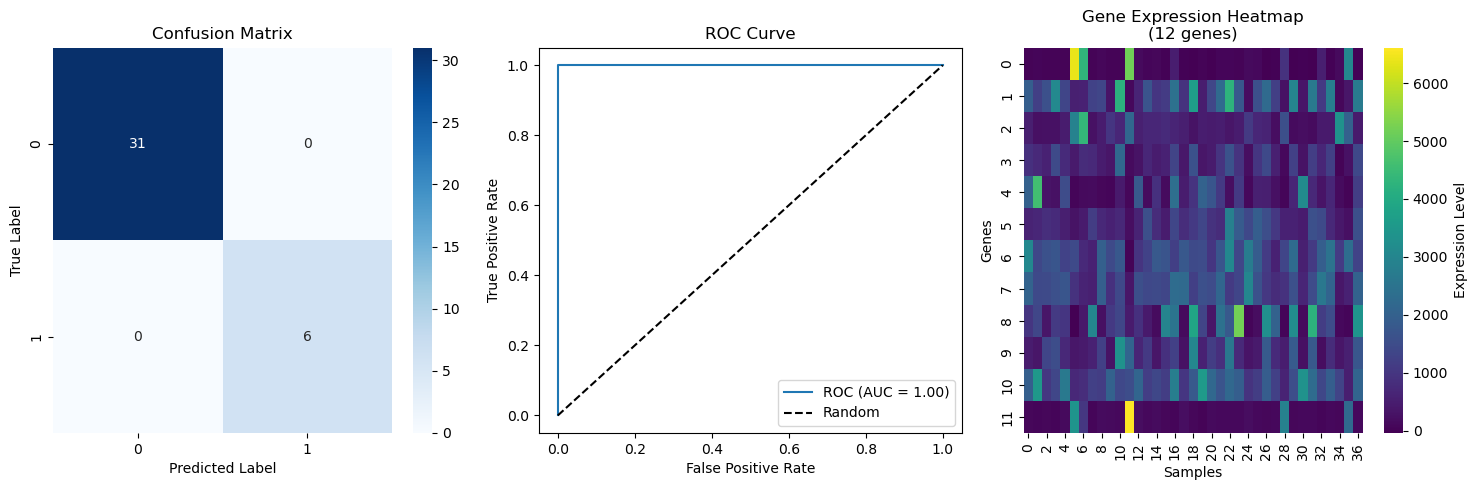


Results for LUNG:
Accuracy: 1.0000
Confusion Matrix:
[[31  0]
 [ 0  6]]
AUC: 1.0000


In [89]:
# ==============================
# MAIN EXECUTION
# ==============================

if __name__ == "__main__":
    # Dataset configuration
    datasets = {
        "LUNG": r"D:\fitchburg\Bu_ML\KTSP\Data\Lung.txt"
        #"Leukemia": r"D:\fitchburg\Bu_ML\KTSP\Data\Leukemia.txt",
        #"Colon": r"D:\fitchburg\Bu_ML\KTSP\Data\Colon.txt",
        # "DLBCL": r"D:\fitchburg\Bu_ML\KTSP\Data\DLBCL.txt",
        #"GCM": r"D:\fitchburg\Bu_ML\KTSP\Data\GCM.txt",
        #"prostate1": r"D:\fitchburg\Bu_ML\KTSP\Data\prostate1.txt",
        #"prostate2": r"D:\fitchburg\Bu_ML\KTSP\Data\prostate2.txt",
        #"prostate3": r"D:\fitchburg\Bu_ML\KTSP\Data\prostate3.txt"
    }
    
    # Parameters
    K = 10
    TOP_GENES = 300
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    
    # Run pipeline for each dataset
    for dataset_name, file_path in datasets.items():
        print(f"\n{'='*60}")
        print(f"Processing dataset: {dataset_name}")
        print(f"{'='*60}")
        
        try:
            # Training pipeline
            print("Running training pipeline...")
            model, selected_genes, gene_pairs = training_pipeline(
                file_path, top_genes=TOP_GENES, K=K
            )
            print(f"Selected {len(selected_genes)} genes")
            print(f"Selected {len(gene_pairs)} gene pairs")
            
            # Load data again for testing (in practice, you'd save X_test, y_test from training)
            X, y = load_and_normalize_data(file_path)
            _, X_test, _, y_test = split_data_processing_labels(
                X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
            )
            
            # Testing pipeline
            print("Running testing pipeline...")
            results = testing_pipeline(model, X_test, y_test, selected_genes, gene_pairs)
            
            print(f"\nResults for {dataset_name}:")
            print(f"Accuracy: {results['accuracy']:.4f}")
            print(f"Confusion Matrix:\n{results['confusion_matrix']}")
            if results['roc_data']:
                print(f"AUC: {results['roc_data']['auc']:.4f}")
        
        except Exception as e:
            print(f"Error processing {dataset_name}: {str(e)}")
            import traceback
            traceback.print_exc()
